In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import time
import seaborn as sns
from matplotlib.colors import ListedColormap

import sys
sys.path.insert(0,'/home/henning/git_repos/ummon3/examples')

import load_mnist

np.set_printoptions(suppress=True, linewidth=np.inf)

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 7.5
plt.rcParams['axes.grid'] = True
plt.gray();

<Figure size 1080x540 with 0 Axes>

In [2]:
# read MNIST data set and scale it
X0,y0,Xv,yv,X1,y1 = load_mnist.read([0,1,2,3,4,5,6,7,8,9], path="")
x0 = (1.0/255.0)*X0.astype('float64')
x1 = (1.0/255.0)*X1.astype('float64')
x2 = (1.0/255.0)*Xv.astype('float64')
y0 = y0.astype('float64')
y1 = y1.astype('float64')
y2 = yv.astype('float64')

MNIST, Classes:     10
Training Images:    (50000, 784)
Validation Images:  (10000, 784)
Test Images:        (10000, 784)


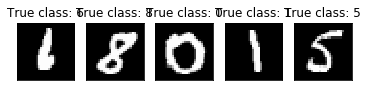

In [3]:
def plot_gallery(data, labels, shape, interpolation='nearest'):
    for i in range(data.shape[0]):
        plt.subplot(1, data.shape[0], (i + 1))
        plt.imshow(data[i].reshape(shape), interpolation=interpolation)
        plt.title(labels[i])
        plt.xticks(()), plt.yticks(())

subsample = np.random.permutation(x0.shape[0])[:5]
images = x0[subsample]
labels = ['True class: %d' % np.argmax(l) for l in y0[subsample]]
plot_gallery(images, labels, shape=(28, 28))

Globale Arrays und Variablen des Netzwerkes:

In [4]:
# Netzwerkparameter
mbs =  32                    # Größe der Minibatches
eta = 0.01                   # Lernrate
no_hidden = 256              # Anzahl versteckter Neuronen
epochs = 1                   # Anzahl Epochen
sizes = [784, no_hidden, 10] # dreischichtiges MPL mit 784 Eingangs-, no_hidden versteckten, 10 Ausgangsneuronen
num_layers = len(sizes)      # Anzahl Schichten

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte
print(weights[1].shape)

(10, 256)


Einige Hilfsfunktionen:

In [5]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    return (output_activations-y)

Vorwärtslauf durch das Netzwerk für Testläufe (Prädiktion):

In [6]:
def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

Backpropagation-Algorithmus für ein Paar aus Input x und Label y:

In [7]:
def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    
    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    
    
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        t = np.dot(weights[-l+1].transpose(), delta)
        delta = t * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert 
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte
    
    return (nabla_b, nabla_w)

Gemitteltes Update über einen Minibatch:

In [8]:
def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()
        
        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        
        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb for b, nb in zip(biases, nabla_b)]
    
    return (weights, biases)

Hilfsfunktion zur Evaluation des Netzwerkes auf den Testdaten:

In [9]:
def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        # Label ist in one-hot-Codierung: korrekte Klasse ist 1, alle anderen 0
        c = np.argmax(y)
        
        # Index des maximal aktivierten Outputs ist die Entscheidung des Netzwerk
        cpred = np.argmax(ypred)
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if c == cpred:
            correct += 1
        
    return correct

Stochastischer Gradientenabstieg:

In [10]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    # gehe durch alle Epochen
    accuracys = np.zeros(epochs)
    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        accuracy_test = evaluate(x2, y2)
        n_test = x2.shape[0]
        percent_test = (accuracy_test / n_test) * 100
        accuracy_train = evaluate(x0, y0)
        n_train = y0.shape[0]
        percent_train = (accuracy_train / n_train) * 100
        print("Epoch: {} / {}, Train-Accuracy: {} / {} ({})%, Test-Accuracy: {} / {} ({})%".format(j, epochs, 
                                                                                                   accuracy_train, n_train, percent_train, 
                                                                                                   accuracy_test, n_test, percent_test))
    
    return accuracys

Training:

In [11]:
start = time.time()
accuracys = SGD(x0, y0, epochs, mbs, eta, x2, y2)
stop = time.time()
print("Elapsed time: {}".format(stop - start))

Epoch: 0 / 1, Train-Accuracy: 7292 / 50000 (14.584)%, Test-Accuracy: 1477 / 10000 (14.77)%
Elapsed time: 44.22038412094116


In [27]:
def generate_data(x_range, y_range, num):
    lx_range, ux_range = x_range
    ly_range, uy_range = y_range
    data = np.asarray([[np.random.uniform(lx_range, ux_range), np.random.uniform(ly_range, uy_range)] for i in range(num)])
    labels = []
    for i, point in enumerate(data):
        x, y = point
        if x < 0 and y < 0:
            labels.append(0)        
        elif x < 0 and y > 0:
            labels.append(1)        
        elif x > 0 and y < 0:
            labels.append(1)        
        else:
            labels.append(0)
    return data, np.asarray(labels)

def evaluate(x2, y2): 
    n = x2.shape[0]
    correct = 0
    
    for i in range(0, n):
        x = np.asarray([x2[i]]).T
        y = np.asarray([y2[i]]).T
        ypred = feedforward(x)
        
        c = y[0]
        cpred = 0
        if ypred > 0.5:
            cpred = 1
        else:
            cpred = 0
            
        if cpred == c:
            correct += 1
        
    return correct

x_range = (-6.0, 6.0)
y_range = (-6.0, 6.0)
num_data = 200
train_data, train_labels = generate_data(x_range, y_range, num_data)
test_data, test_labels = generate_data(x_range, y_range, num_data)

mbs = 10
eta = 0.01
epochs = 10000
sizes = [2, 6, 3, 1]
num_layers = len(sizes)

biases = [np.random.randn(y, 1) for y in sizes[1:]]
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
accuracys = SGD(train_data, train_labels, epochs, mbs, eta, test_data, test_labels)

Epoch: 0 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 1 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 2 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 3 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 4 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 5 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 6 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 7 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 8 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 9 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 10 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 11 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accur

Epoch: 97 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 98 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 99 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 100 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 101 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 102 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 103 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 104 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 105 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 106 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 107 / 10000, Train-Accuracy: 107 / 200 (53.5)%, Test-Accuracy: 96 / 200 (48.0)%
Epoch: 108 / 10000, Train-Accuracy: 107 / 200 

Epoch: 195 / 10000, Train-Accuracy: 112 / 200 (56.00000000000001)%, Test-Accuracy: 99 / 200 (49.5)%
Epoch: 196 / 10000, Train-Accuracy: 112 / 200 (56.00000000000001)%, Test-Accuracy: 99 / 200 (49.5)%
Epoch: 197 / 10000, Train-Accuracy: 112 / 200 (56.00000000000001)%, Test-Accuracy: 99 / 200 (49.5)%
Epoch: 198 / 10000, Train-Accuracy: 112 / 200 (56.00000000000001)%, Test-Accuracy: 99 / 200 (49.5)%
Epoch: 199 / 10000, Train-Accuracy: 112 / 200 (56.00000000000001)%, Test-Accuracy: 99 / 200 (49.5)%
Epoch: 200 / 10000, Train-Accuracy: 112 / 200 (56.00000000000001)%, Test-Accuracy: 99 / 200 (49.5)%
Epoch: 201 / 10000, Train-Accuracy: 112 / 200 (56.00000000000001)%, Test-Accuracy: 99 / 200 (49.5)%
Epoch: 202 / 10000, Train-Accuracy: 112 / 200 (56.00000000000001)%, Test-Accuracy: 99 / 200 (49.5)%
Epoch: 203 / 10000, Train-Accuracy: 112 / 200 (56.00000000000001)%, Test-Accuracy: 99 / 200 (49.5)%
Epoch: 204 / 10000, Train-Accuracy: 112 / 200 (56.00000000000001)%, Test-Accuracy: 99 / 200 (49.5)%


Epoch: 279 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 100 / 200 (50.0)%
Epoch: 280 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 100 / 200 (50.0)%
Epoch: 281 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 100 / 200 (50.0)%
Epoch: 282 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 100 / 200 (50.0)%
Epoch: 283 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 100 / 200 (50.0)%
Epoch: 284 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 100 / 200 (50.0)%
Epoch: 285 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 100 / 200 (50.0)%
Epoch: 286 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 100 / 200 (50.0)%
Epoch: 287 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 100 / 200 (50.0)%
Epoch: 288 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 100 / 20

Epoch: 366 / 10000, Train-Accuracy: 114 / 200 (56.99999999999999)%, Test-Accuracy: 104 / 200 (52.0)%
Epoch: 367 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 104 / 200 (52.0)%
Epoch: 368 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 104 / 200 (52.0)%
Epoch: 369 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 104 / 200 (52.0)%
Epoch: 370 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 104 / 200 (52.0)%
Epoch: 371 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 104 / 200 (52.0)%
Epoch: 372 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 104 / 200 (52.0)%
Epoch: 373 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 104 / 200 (52.0)%
Epoch: 374 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 104 / 200 (52.0)%
Epoch: 375 / 10000, Train-Accuracy: 115 / 200 (57.49999999999999)%, Test-Accuracy: 104 / 20

Epoch: 453 / 10000, Train-Accuracy: 118 / 200 (59.0)%, Test-Accuracy: 110 / 200 (55.00000000000001)%
Epoch: 454 / 10000, Train-Accuracy: 118 / 200 (59.0)%, Test-Accuracy: 110 / 200 (55.00000000000001)%
Epoch: 455 / 10000, Train-Accuracy: 118 / 200 (59.0)%, Test-Accuracy: 111 / 200 (55.50000000000001)%
Epoch: 456 / 10000, Train-Accuracy: 118 / 200 (59.0)%, Test-Accuracy: 111 / 200 (55.50000000000001)%
Epoch: 457 / 10000, Train-Accuracy: 119 / 200 (59.5)%, Test-Accuracy: 111 / 200 (55.50000000000001)%
Epoch: 458 / 10000, Train-Accuracy: 119 / 200 (59.5)%, Test-Accuracy: 111 / 200 (55.50000000000001)%
Epoch: 459 / 10000, Train-Accuracy: 119 / 200 (59.5)%, Test-Accuracy: 111 / 200 (55.50000000000001)%
Epoch: 460 / 10000, Train-Accuracy: 119 / 200 (59.5)%, Test-Accuracy: 112 / 200 (56.00000000000001)%
Epoch: 461 / 10000, Train-Accuracy: 119 / 200 (59.5)%, Test-Accuracy: 112 / 200 (56.00000000000001)%
Epoch: 462 / 10000, Train-Accuracy: 119 / 200 (59.5)%, Test-Accuracy: 112 / 200 (56.0000000

Epoch: 539 / 10000, Train-Accuracy: 125 / 200 (62.5)%, Test-Accuracy: 117 / 200 (58.5)%
Epoch: 540 / 10000, Train-Accuracy: 125 / 200 (62.5)%, Test-Accuracy: 117 / 200 (58.5)%
Epoch: 541 / 10000, Train-Accuracy: 125 / 200 (62.5)%, Test-Accuracy: 117 / 200 (58.5)%
Epoch: 542 / 10000, Train-Accuracy: 125 / 200 (62.5)%, Test-Accuracy: 117 / 200 (58.5)%
Epoch: 543 / 10000, Train-Accuracy: 125 / 200 (62.5)%, Test-Accuracy: 117 / 200 (58.5)%
Epoch: 544 / 10000, Train-Accuracy: 125 / 200 (62.5)%, Test-Accuracy: 117 / 200 (58.5)%
Epoch: 545 / 10000, Train-Accuracy: 125 / 200 (62.5)%, Test-Accuracy: 117 / 200 (58.5)%
Epoch: 546 / 10000, Train-Accuracy: 125 / 200 (62.5)%, Test-Accuracy: 117 / 200 (58.5)%
Epoch: 547 / 10000, Train-Accuracy: 125 / 200 (62.5)%, Test-Accuracy: 117 / 200 (58.5)%
Epoch: 548 / 10000, Train-Accuracy: 125 / 200 (62.5)%, Test-Accuracy: 117 / 200 (58.5)%
Epoch: 549 / 10000, Train-Accuracy: 125 / 200 (62.5)%, Test-Accuracy: 117 / 200 (58.5)%
Epoch: 550 / 10000, Train-Accura

Epoch: 637 / 10000, Train-Accuracy: 132 / 200 (66.0)%, Test-Accuracy: 123 / 200 (61.5)%
Epoch: 638 / 10000, Train-Accuracy: 132 / 200 (66.0)%, Test-Accuracy: 123 / 200 (61.5)%
Epoch: 639 / 10000, Train-Accuracy: 132 / 200 (66.0)%, Test-Accuracy: 124 / 200 (62.0)%
Epoch: 640 / 10000, Train-Accuracy: 132 / 200 (66.0)%, Test-Accuracy: 124 / 200 (62.0)%
Epoch: 641 / 10000, Train-Accuracy: 132 / 200 (66.0)%, Test-Accuracy: 124 / 200 (62.0)%
Epoch: 642 / 10000, Train-Accuracy: 132 / 200 (66.0)%, Test-Accuracy: 124 / 200 (62.0)%
Epoch: 643 / 10000, Train-Accuracy: 132 / 200 (66.0)%, Test-Accuracy: 124 / 200 (62.0)%
Epoch: 644 / 10000, Train-Accuracy: 132 / 200 (66.0)%, Test-Accuracy: 124 / 200 (62.0)%
Epoch: 645 / 10000, Train-Accuracy: 132 / 200 (66.0)%, Test-Accuracy: 124 / 200 (62.0)%
Epoch: 646 / 10000, Train-Accuracy: 132 / 200 (66.0)%, Test-Accuracy: 124 / 200 (62.0)%
Epoch: 647 / 10000, Train-Accuracy: 132 / 200 (66.0)%, Test-Accuracy: 124 / 200 (62.0)%
Epoch: 648 / 10000, Train-Accura

Epoch: 736 / 10000, Train-Accuracy: 134 / 200 (67.0)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 737 / 10000, Train-Accuracy: 135 / 200 (67.5)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 738 / 10000, Train-Accuracy: 135 / 200 (67.5)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 739 / 10000, Train-Accuracy: 135 / 200 (67.5)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 740 / 10000, Train-Accuracy: 135 / 200 (67.5)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 741 / 10000, Train-Accuracy: 135 / 200 (67.5)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 742 / 10000, Train-Accuracy: 135 / 200 (67.5)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 743 / 10000, Train-Accuracy: 135 / 200 (67.5)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 744 / 10000, Train-Accuracy: 135 / 200 (67.5)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 745 / 10000, Train-Accuracy: 135 / 200 (67.5)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 746 / 10000, Train-Accuracy: 135 / 200 (67.5)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 747 / 10000, Train-Accura

Epoch: 835 / 10000, Train-Accuracy: 138 / 200 (69.0)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 836 / 10000, Train-Accuracy: 138 / 200 (69.0)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 837 / 10000, Train-Accuracy: 138 / 200 (69.0)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 838 / 10000, Train-Accuracy: 138 / 200 (69.0)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 839 / 10000, Train-Accuracy: 138 / 200 (69.0)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 840 / 10000, Train-Accuracy: 138 / 200 (69.0)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 841 / 10000, Train-Accuracy: 138 / 200 (69.0)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 842 / 10000, Train-Accuracy: 138 / 200 (69.0)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 843 / 10000, Train-Accuracy: 138 / 200 (69.0)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 844 / 10000, Train-Accuracy: 138 / 200 (69.0)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 845 / 10000, Train-Accuracy: 138 / 200 (69.0)%, Test-Accuracy: 126 / 200 (63.0)%
Epoch: 846 / 10000, Train-Accura

Epoch: 932 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 933 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 934 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 935 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 936 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 937 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 938 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 939 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 940 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 941 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 942 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 943 / 10000, Train-Accura

Epoch: 1027 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 129 / 200 (64.5)%
Epoch: 1028 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 129 / 200 (64.5)%
Epoch: 1029 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1030 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1031 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1032 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1033 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1034 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1035 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1036 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1037 / 10000, Train-Accuracy: 140 / 200 (70.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1038 / 10000, 

Epoch: 1122 / 10000, Train-Accuracy: 141 / 200 (70.5)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1123 / 10000, Train-Accuracy: 141 / 200 (70.5)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1124 / 10000, Train-Accuracy: 141 / 200 (70.5)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1125 / 10000, Train-Accuracy: 141 / 200 (70.5)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1126 / 10000, Train-Accuracy: 141 / 200 (70.5)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1127 / 10000, Train-Accuracy: 141 / 200 (70.5)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1128 / 10000, Train-Accuracy: 141 / 200 (70.5)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1129 / 10000, Train-Accuracy: 141 / 200 (70.5)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1130 / 10000, Train-Accuracy: 141 / 200 (70.5)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1131 / 10000, Train-Accuracy: 141 / 200 (70.5)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1132 / 10000, Train-Accuracy: 141 / 200 (70.5)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1133 / 10000, 

Epoch: 1221 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1222 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1223 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1224 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1225 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1226 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1227 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1228 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1229 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1230 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1231 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 128 / 200 (64.0)%
Epoch: 1232 / 10000, 

Epoch: 1318 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1319 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1320 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1321 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1322 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1323 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1324 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1325 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1326 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1327 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1328 / 10000, Train-Accuracy: 142 / 200 (71.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1329 / 10000, 

Epoch: 1413 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1414 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1415 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1416 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1417 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1418 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1419 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1420 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1421 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1422 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1423 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1424 / 10000, 

Epoch: 1513 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1514 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1515 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1516 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1517 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1518 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1519 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1520 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1521 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1522 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1523 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1524 / 10000, 

Epoch: 1612 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1613 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1614 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1615 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1616 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1617 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1618 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1619 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1620 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1621 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1622 / 10000, Train-Accuracy: 143 / 200 (71.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1623 / 10000, 

Epoch: 1707 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1708 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1709 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1710 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1711 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1712 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1713 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1714 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1715 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1716 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1717 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1718 / 10000, 

Epoch: 1802 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1803 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1804 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1805 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1806 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1807 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1808 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1809 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1810 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1811 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1812 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1813 / 10000, 

Epoch: 1896 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1897 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1898 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1899 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1900 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1901 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1902 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1903 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1904 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1905 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1906 / 10000, Train-Accuracy: 144 / 200 (72.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1907 / 10000, 

Epoch: 1990 / 10000, Train-Accuracy: 146 / 200 (73.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1991 / 10000, Train-Accuracy: 146 / 200 (73.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1992 / 10000, Train-Accuracy: 146 / 200 (73.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1993 / 10000, Train-Accuracy: 146 / 200 (73.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1994 / 10000, Train-Accuracy: 146 / 200 (73.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1995 / 10000, Train-Accuracy: 146 / 200 (73.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1996 / 10000, Train-Accuracy: 146 / 200 (73.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1997 / 10000, Train-Accuracy: 146 / 200 (73.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1998 / 10000, Train-Accuracy: 146 / 200 (73.0)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 1999 / 10000, Train-Accuracy: 147 / 200 (73.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 2000 / 10000, Train-Accuracy: 147 / 200 (73.5)%, Test-Accuracy: 131 / 200 (65.5)%
Epoch: 2001 / 10000, 

Epoch: 2088 / 10000, Train-Accuracy: 155 / 200 (77.5)%, Test-Accuracy: 141 / 200 (70.5)%
Epoch: 2089 / 10000, Train-Accuracy: 155 / 200 (77.5)%, Test-Accuracy: 141 / 200 (70.5)%
Epoch: 2090 / 10000, Train-Accuracy: 155 / 200 (77.5)%, Test-Accuracy: 141 / 200 (70.5)%
Epoch: 2091 / 10000, Train-Accuracy: 155 / 200 (77.5)%, Test-Accuracy: 141 / 200 (70.5)%
Epoch: 2092 / 10000, Train-Accuracy: 155 / 200 (77.5)%, Test-Accuracy: 141 / 200 (70.5)%
Epoch: 2093 / 10000, Train-Accuracy: 155 / 200 (77.5)%, Test-Accuracy: 141 / 200 (70.5)%
Epoch: 2094 / 10000, Train-Accuracy: 155 / 200 (77.5)%, Test-Accuracy: 141 / 200 (70.5)%
Epoch: 2095 / 10000, Train-Accuracy: 155 / 200 (77.5)%, Test-Accuracy: 141 / 200 (70.5)%
Epoch: 2096 / 10000, Train-Accuracy: 156 / 200 (78.0)%, Test-Accuracy: 141 / 200 (70.5)%
Epoch: 2097 / 10000, Train-Accuracy: 156 / 200 (78.0)%, Test-Accuracy: 141 / 200 (70.5)%
Epoch: 2098 / 10000, Train-Accuracy: 156 / 200 (78.0)%, Test-Accuracy: 141 / 200 (70.5)%
Epoch: 2099 / 10000, 

Epoch: 2186 / 10000, Train-Accuracy: 159 / 200 (79.5)%, Test-Accuracy: 151 / 200 (75.5)%
Epoch: 2187 / 10000, Train-Accuracy: 159 / 200 (79.5)%, Test-Accuracy: 151 / 200 (75.5)%
Epoch: 2188 / 10000, Train-Accuracy: 159 / 200 (79.5)%, Test-Accuracy: 152 / 200 (76.0)%
Epoch: 2189 / 10000, Train-Accuracy: 159 / 200 (79.5)%, Test-Accuracy: 152 / 200 (76.0)%
Epoch: 2190 / 10000, Train-Accuracy: 159 / 200 (79.5)%, Test-Accuracy: 152 / 200 (76.0)%
Epoch: 2191 / 10000, Train-Accuracy: 159 / 200 (79.5)%, Test-Accuracy: 152 / 200 (76.0)%
Epoch: 2192 / 10000, Train-Accuracy: 159 / 200 (79.5)%, Test-Accuracy: 152 / 200 (76.0)%
Epoch: 2193 / 10000, Train-Accuracy: 159 / 200 (79.5)%, Test-Accuracy: 152 / 200 (76.0)%
Epoch: 2194 / 10000, Train-Accuracy: 159 / 200 (79.5)%, Test-Accuracy: 152 / 200 (76.0)%
Epoch: 2195 / 10000, Train-Accuracy: 159 / 200 (79.5)%, Test-Accuracy: 152 / 200 (76.0)%
Epoch: 2196 / 10000, Train-Accuracy: 159 / 200 (79.5)%, Test-Accuracy: 152 / 200 (76.0)%
Epoch: 2197 / 10000, 

Epoch: 2286 / 10000, Train-Accuracy: 166 / 200 (83.0)%, Test-Accuracy: 158 / 200 (79.0)%
Epoch: 2287 / 10000, Train-Accuracy: 166 / 200 (83.0)%, Test-Accuracy: 159 / 200 (79.5)%
Epoch: 2288 / 10000, Train-Accuracy: 166 / 200 (83.0)%, Test-Accuracy: 159 / 200 (79.5)%
Epoch: 2289 / 10000, Train-Accuracy: 166 / 200 (83.0)%, Test-Accuracy: 159 / 200 (79.5)%
Epoch: 2290 / 10000, Train-Accuracy: 166 / 200 (83.0)%, Test-Accuracy: 159 / 200 (79.5)%
Epoch: 2291 / 10000, Train-Accuracy: 166 / 200 (83.0)%, Test-Accuracy: 159 / 200 (79.5)%
Epoch: 2292 / 10000, Train-Accuracy: 166 / 200 (83.0)%, Test-Accuracy: 159 / 200 (79.5)%
Epoch: 2293 / 10000, Train-Accuracy: 166 / 200 (83.0)%, Test-Accuracy: 159 / 200 (79.5)%
Epoch: 2294 / 10000, Train-Accuracy: 166 / 200 (83.0)%, Test-Accuracy: 160 / 200 (80.0)%
Epoch: 2295 / 10000, Train-Accuracy: 166 / 200 (83.0)%, Test-Accuracy: 160 / 200 (80.0)%
Epoch: 2296 / 10000, Train-Accuracy: 166 / 200 (83.0)%, Test-Accuracy: 160 / 200 (80.0)%
Epoch: 2297 / 10000, 

Epoch: 2385 / 10000, Train-Accuracy: 175 / 200 (87.5)%, Test-Accuracy: 165 / 200 (82.5)%
Epoch: 2386 / 10000, Train-Accuracy: 176 / 200 (88.0)%, Test-Accuracy: 165 / 200 (82.5)%
Epoch: 2387 / 10000, Train-Accuracy: 176 / 200 (88.0)%, Test-Accuracy: 165 / 200 (82.5)%
Epoch: 2388 / 10000, Train-Accuracy: 176 / 200 (88.0)%, Test-Accuracy: 165 / 200 (82.5)%
Epoch: 2389 / 10000, Train-Accuracy: 176 / 200 (88.0)%, Test-Accuracy: 165 / 200 (82.5)%
Epoch: 2390 / 10000, Train-Accuracy: 176 / 200 (88.0)%, Test-Accuracy: 166 / 200 (83.0)%
Epoch: 2391 / 10000, Train-Accuracy: 176 / 200 (88.0)%, Test-Accuracy: 166 / 200 (83.0)%
Epoch: 2392 / 10000, Train-Accuracy: 177 / 200 (88.5)%, Test-Accuracy: 167 / 200 (83.5)%
Epoch: 2393 / 10000, Train-Accuracy: 177 / 200 (88.5)%, Test-Accuracy: 167 / 200 (83.5)%
Epoch: 2394 / 10000, Train-Accuracy: 177 / 200 (88.5)%, Test-Accuracy: 167 / 200 (83.5)%
Epoch: 2395 / 10000, Train-Accuracy: 178 / 200 (89.0)%, Test-Accuracy: 167 / 200 (83.5)%
Epoch: 2396 / 10000, 

Epoch: 2478 / 10000, Train-Accuracy: 179 / 200 (89.5)%, Test-Accuracy: 174 / 200 (87.0)%
Epoch: 2479 / 10000, Train-Accuracy: 179 / 200 (89.5)%, Test-Accuracy: 175 / 200 (87.5)%
Epoch: 2480 / 10000, Train-Accuracy: 179 / 200 (89.5)%, Test-Accuracy: 175 / 200 (87.5)%
Epoch: 2481 / 10000, Train-Accuracy: 179 / 200 (89.5)%, Test-Accuracy: 175 / 200 (87.5)%
Epoch: 2482 / 10000, Train-Accuracy: 179 / 200 (89.5)%, Test-Accuracy: 175 / 200 (87.5)%
Epoch: 2483 / 10000, Train-Accuracy: 179 / 200 (89.5)%, Test-Accuracy: 176 / 200 (88.0)%
Epoch: 2484 / 10000, Train-Accuracy: 179 / 200 (89.5)%, Test-Accuracy: 176 / 200 (88.0)%
Epoch: 2485 / 10000, Train-Accuracy: 179 / 200 (89.5)%, Test-Accuracy: 176 / 200 (88.0)%
Epoch: 2486 / 10000, Train-Accuracy: 179 / 200 (89.5)%, Test-Accuracy: 176 / 200 (88.0)%
Epoch: 2487 / 10000, Train-Accuracy: 179 / 200 (89.5)%, Test-Accuracy: 176 / 200 (88.0)%
Epoch: 2488 / 10000, Train-Accuracy: 179 / 200 (89.5)%, Test-Accuracy: 176 / 200 (88.0)%
Epoch: 2489 / 10000, 

Epoch: 2574 / 10000, Train-Accuracy: 183 / 200 (91.5)%, Test-Accuracy: 177 / 200 (88.5)%
Epoch: 2575 / 10000, Train-Accuracy: 184 / 200 (92.0)%, Test-Accuracy: 177 / 200 (88.5)%
Epoch: 2576 / 10000, Train-Accuracy: 184 / 200 (92.0)%, Test-Accuracy: 177 / 200 (88.5)%
Epoch: 2577 / 10000, Train-Accuracy: 184 / 200 (92.0)%, Test-Accuracy: 177 / 200 (88.5)%
Epoch: 2578 / 10000, Train-Accuracy: 184 / 200 (92.0)%, Test-Accuracy: 177 / 200 (88.5)%
Epoch: 2579 / 10000, Train-Accuracy: 184 / 200 (92.0)%, Test-Accuracy: 177 / 200 (88.5)%
Epoch: 2580 / 10000, Train-Accuracy: 184 / 200 (92.0)%, Test-Accuracy: 177 / 200 (88.5)%
Epoch: 2581 / 10000, Train-Accuracy: 184 / 200 (92.0)%, Test-Accuracy: 177 / 200 (88.5)%
Epoch: 2582 / 10000, Train-Accuracy: 184 / 200 (92.0)%, Test-Accuracy: 178 / 200 (89.0)%
Epoch: 2583 / 10000, Train-Accuracy: 184 / 200 (92.0)%, Test-Accuracy: 178 / 200 (89.0)%
Epoch: 2584 / 10000, Train-Accuracy: 184 / 200 (92.0)%, Test-Accuracy: 178 / 200 (89.0)%
Epoch: 2585 / 10000, 

Epoch: 2670 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 180 / 200 (90.0)%
Epoch: 2671 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 180 / 200 (90.0)%
Epoch: 2672 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 180 / 200 (90.0)%
Epoch: 2673 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 180 / 200 (90.0)%
Epoch: 2674 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 180 / 200 (90.0)%
Epoch: 2675 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 180 / 200 (90.0)%
Epoch: 2676 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 180 / 200 (90.0)%
Epoch: 2677 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 180 / 200 (90.0)%
Epoch: 2678 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 180 / 200 (90.0)%
Epoch: 2679 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 180 / 200 (90.0)%
Epoch: 2680 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 180 / 200 (90.0)%
Epoch: 2681 / 10000, 

Epoch: 2769 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 181 / 200 (90.5)%
Epoch: 2770 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 181 / 200 (90.5)%
Epoch: 2771 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 181 / 200 (90.5)%
Epoch: 2772 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 181 / 200 (90.5)%
Epoch: 2773 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 181 / 200 (90.5)%
Epoch: 2774 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 181 / 200 (90.5)%
Epoch: 2775 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 181 / 200 (90.5)%
Epoch: 2776 / 10000, Train-Accuracy: 185 / 200 (92.5)%, Test-Accuracy: 181 / 200 (90.5)%
Epoch: 2777 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 181 / 200 (90.5)%
Epoch: 2778 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 181 / 200 (90.5)%
Epoch: 2779 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 181 / 200 (90.5)%
Epoch: 2780 / 10000, 

Epoch: 2868 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2869 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2870 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2871 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2872 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2873 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2874 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2875 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2876 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2877 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2878 / 10000, Train-Accuracy: 186 / 200 (93.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2879 / 10000, 

Epoch: 2961 / 10000, Train-Accuracy: 187 / 200 (93.5)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2962 / 10000, Train-Accuracy: 187 / 200 (93.5)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2963 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2964 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2965 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2966 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2967 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2968 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2969 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2970 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2971 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 2972 / 10000, 

Epoch: 3061 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 3062 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 3063 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 3064 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 3065 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 3066 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 3067 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 3068 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 3069 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 3070 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 3071 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 182 / 200 (91.0)%
Epoch: 3072 / 10000, 

Epoch: 3158 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 183 / 200 (91.5)%
Epoch: 3159 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 183 / 200 (91.5)%
Epoch: 3160 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 183 / 200 (91.5)%
Epoch: 3161 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 183 / 200 (91.5)%
Epoch: 3162 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 183 / 200 (91.5)%
Epoch: 3163 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3164 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3165 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3166 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3167 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3168 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3169 / 10000, 

Epoch: 3255 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3256 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3257 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3258 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3259 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3260 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3261 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3262 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3263 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3264 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3265 / 10000, Train-Accuracy: 188 / 200 (94.0)%, Test-Accuracy: 184 / 200 (92.0)%
Epoch: 3266 / 10000, 

Epoch: 3353 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3354 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3355 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3356 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3357 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3358 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3359 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3360 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3361 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3362 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3363 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3364 / 10000, 

Epoch: 3448 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3449 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3450 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3451 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3452 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3453 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3454 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3455 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3456 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3457 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3458 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3459 / 10000, 

Epoch: 3542 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3543 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3544 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3545 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3546 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3547 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3548 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3549 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3550 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3551 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3552 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3553 / 10000, 

Epoch: 3636 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3637 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3638 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3639 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3640 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3641 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3642 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3643 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3644 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3645 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3646 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3647 / 10000, 

Epoch: 3730 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3731 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3732 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3733 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3734 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3735 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3736 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3737 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3738 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3739 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3740 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3741 / 10000, 

Epoch: 3825 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3826 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3827 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3828 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3829 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3830 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3831 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3832 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3833 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3834 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3835 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3836 / 10000, 

Epoch: 3921 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3922 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3923 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3924 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3925 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3926 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3927 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3928 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3929 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3930 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3931 / 10000, Train-Accuracy: 189 / 200 (94.5)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 3932 / 10000, 

Epoch: 4014 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4015 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4016 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4017 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4018 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4019 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4020 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4021 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4022 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4023 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4024 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4025 / 10000, 

Epoch: 4107 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4108 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4109 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4110 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4111 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4112 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4113 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4114 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4115 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4116 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4117 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 185 / 200 (92.5)%
Epoch: 4118 / 10000, 

Epoch: 4200 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4201 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4202 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4203 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4204 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4205 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4206 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4207 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4208 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4209 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4210 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4211 / 10000, 

Epoch: 4300 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4301 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4302 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4303 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4304 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4305 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4306 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4307 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4308 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4309 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 187 / 200 (93.5)%
Epoch: 4310 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4311 / 10000, 

Epoch: 4396 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4397 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4398 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4399 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4400 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4401 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4402 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4403 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4404 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4405 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4406 / 10000, Train-Accuracy: 190 / 200 (95.0)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4407 / 10000, 

Epoch: 4492 / 10000, Train-Accuracy: 191 / 200 (95.5)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4493 / 10000, Train-Accuracy: 191 / 200 (95.5)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4494 / 10000, Train-Accuracy: 191 / 200 (95.5)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4495 / 10000, Train-Accuracy: 191 / 200 (95.5)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4496 / 10000, Train-Accuracy: 191 / 200 (95.5)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4497 / 10000, Train-Accuracy: 191 / 200 (95.5)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4498 / 10000, Train-Accuracy: 191 / 200 (95.5)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4499 / 10000, Train-Accuracy: 191 / 200 (95.5)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4500 / 10000, Train-Accuracy: 191 / 200 (95.5)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4501 / 10000, Train-Accuracy: 191 / 200 (95.5)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4502 / 10000, Train-Accuracy: 191 / 200 (95.5)%, Test-Accuracy: 188 / 200 (94.0)%
Epoch: 4503 / 10000, 

Epoch: 4592 / 10000, Train-Accuracy: 192 / 200 (96.0)%, Test-Accuracy: 189 / 200 (94.5)%
Epoch: 4593 / 10000, Train-Accuracy: 192 / 200 (96.0)%, Test-Accuracy: 189 / 200 (94.5)%
Epoch: 4594 / 10000, Train-Accuracy: 192 / 200 (96.0)%, Test-Accuracy: 189 / 200 (94.5)%
Epoch: 4595 / 10000, Train-Accuracy: 192 / 200 (96.0)%, Test-Accuracy: 189 / 200 (94.5)%
Epoch: 4596 / 10000, Train-Accuracy: 192 / 200 (96.0)%, Test-Accuracy: 189 / 200 (94.5)%
Epoch: 4597 / 10000, Train-Accuracy: 192 / 200 (96.0)%, Test-Accuracy: 189 / 200 (94.5)%
Epoch: 4598 / 10000, Train-Accuracy: 192 / 200 (96.0)%, Test-Accuracy: 189 / 200 (94.5)%
Epoch: 4599 / 10000, Train-Accuracy: 192 / 200 (96.0)%, Test-Accuracy: 189 / 200 (94.5)%
Epoch: 4600 / 10000, Train-Accuracy: 192 / 200 (96.0)%, Test-Accuracy: 189 / 200 (94.5)%
Epoch: 4601 / 10000, Train-Accuracy: 192 / 200 (96.0)%, Test-Accuracy: 189 / 200 (94.5)%
Epoch: 4602 / 10000, Train-Accuracy: 192 / 200 (96.0)%, Test-Accuracy: 189 / 200 (94.5)%
Epoch: 4603 / 10000, 

Epoch: 4690 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4691 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4692 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4693 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4694 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4695 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4696 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4697 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4698 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4699 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4700 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4701 / 10000, 

Epoch: 4791 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4792 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4793 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4794 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4795 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4796 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4797 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4798 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4799 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4800 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4801 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4802 / 10000, 

Epoch: 4886 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4887 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4888 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4889 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4890 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4891 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4892 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4893 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4894 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4895 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4896 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4897 / 10000, 

Epoch: 4982 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4983 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4984 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4985 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4986 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4987 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4988 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4989 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4990 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4991 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4992 / 10000, Train-Accuracy: 193 / 200 (96.5)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 4993 / 10000, 

Epoch: 5078 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5079 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5080 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5081 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5082 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5083 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5084 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5085 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5086 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5087 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5088 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5089 / 10000, 

Epoch: 5173 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5174 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5175 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5176 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5177 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5178 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5179 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5180 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5181 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5182 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5183 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5184 / 10000, 

Epoch: 5268 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5269 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5270 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5271 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5272 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5273 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5274 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5275 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5276 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5277 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5278 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 190 / 200 (95.0)%
Epoch: 5279 / 10000, 

Epoch: 5363 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5364 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5365 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5366 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5367 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5368 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5369 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5370 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5371 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5372 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5373 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5374 / 10000, 

Epoch: 5461 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5462 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5463 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5464 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5465 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5466 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5467 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5468 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5469 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5470 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5471 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5472 / 10000, 

Epoch: 5554 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5555 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5556 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5557 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5558 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5559 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5560 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5561 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5562 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5563 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5564 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5565 / 10000, 

Epoch: 5647 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5648 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5649 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5650 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5651 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5652 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5653 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5654 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5655 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5656 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5657 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5658 / 10000, 

Epoch: 5746 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5747 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5748 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5749 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5750 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5751 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5752 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5753 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5754 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5755 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5756 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5757 / 10000, 

Epoch: 5844 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5845 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5846 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5847 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5848 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5849 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5850 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5851 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5852 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5853 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5854 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5855 / 10000, 

Epoch: 5944 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5945 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5946 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5947 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5948 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5949 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5950 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5951 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5952 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5953 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5954 / 10000, Train-Accuracy: 194 / 200 (97.0)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 5955 / 10000, 

Epoch: 6042 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6043 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6044 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6045 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6046 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6047 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6048 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6049 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6050 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6051 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6052 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6053 / 10000, 

Epoch: 6139 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6140 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6141 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6142 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6143 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6144 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6145 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6146 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6147 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6148 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6149 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6150 / 10000, 

Epoch: 6239 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6240 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6241 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6242 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6243 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6244 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6245 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6246 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6247 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6248 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6249 / 10000, Train-Accuracy: 195 / 200 (97.5)%, Test-Accuracy: 191 / 200 (95.5)%
Epoch: 6250 / 10000, 

Epoch: 6335 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6336 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6337 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6338 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6339 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6340 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6341 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6342 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6343 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6344 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6345 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6346 / 10000, 

Epoch: 6434 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6435 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6436 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6437 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6438 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6439 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6440 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6441 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6442 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6443 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6444 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6445 / 10000, 

Epoch: 6535 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6536 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6537 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6538 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6539 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6540 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6541 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6542 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6543 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6544 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6545 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6546 / 10000, 

Epoch: 6630 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6631 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6632 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6633 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6634 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6635 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6636 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6637 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 192 / 200 (96.0)%
Epoch: 6638 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 193 / 200 (96.5)%
Epoch: 6639 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 193 / 200 (96.5)%
Epoch: 6640 / 10000, Train-Accuracy: 196 / 200 (98.0)%, Test-Accuracy: 193 / 200 (96.5)%
Epoch: 6641 / 10000, 

Epoch: 6730 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6731 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6732 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6733 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6734 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6735 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6736 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6737 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6738 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6739 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6740 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6741 / 10000, 

Epoch: 6829 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6830 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6831 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6832 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6833 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6834 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6835 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6836 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6837 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6838 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6839 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6840 / 10000, 

Epoch: 6928 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6929 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6930 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6931 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6932 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6933 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6934 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6935 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6936 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6937 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6938 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 6939 / 10000, 

Epoch: 7025 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7026 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7027 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7028 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7029 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7030 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7031 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7032 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7033 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7034 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7035 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7036 / 10000, 

Epoch: 7122 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7123 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7124 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7125 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7126 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7127 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7128 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7129 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7130 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7131 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7132 / 10000, Train-Accuracy: 197 / 200 (98.5)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7133 / 10000, 

Epoch: 7220 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7221 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7222 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7223 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7224 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7225 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7226 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7227 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7228 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7229 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7230 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7231 / 10000, 

Epoch: 7318 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7319 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7320 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7321 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7322 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7323 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7324 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7325 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7326 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7327 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7328 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7329 / 10000, 

Epoch: 7414 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7415 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7416 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7417 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7418 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7419 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7420 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7421 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7422 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7423 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7424 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 194 / 200 (97.0)%
Epoch: 7425 / 10000, 

Epoch: 7511 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7512 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7513 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7514 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7515 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7516 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7517 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7518 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7519 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7520 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7521 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7522 / 10000, 

Epoch: 7609 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7610 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7611 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7612 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7613 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7614 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7615 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7616 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7617 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7618 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7619 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7620 / 10000, 

Epoch: 7704 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7705 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7706 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7707 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7708 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7709 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7710 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7711 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7712 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7713 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7714 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7715 / 10000, 

Epoch: 7801 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7802 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7803 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7804 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7805 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7806 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7807 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7808 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7809 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7810 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7811 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 195 / 200 (97.5)%
Epoch: 7812 / 10000, 

Epoch: 7896 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 196 / 200 (98.0)%
Epoch: 7897 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 196 / 200 (98.0)%
Epoch: 7898 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 196 / 200 (98.0)%
Epoch: 7899 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 196 / 200 (98.0)%
Epoch: 7900 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 196 / 200 (98.0)%
Epoch: 7901 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 196 / 200 (98.0)%
Epoch: 7902 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 196 / 200 (98.0)%
Epoch: 7903 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 196 / 200 (98.0)%
Epoch: 7904 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 196 / 200 (98.0)%
Epoch: 7905 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 196 / 200 (98.0)%
Epoch: 7906 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 196 / 200 (98.0)%
Epoch: 7907 / 10000, 

Epoch: 7991 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 7992 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 7993 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 7994 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 7995 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 7996 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 7997 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 7998 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 7999 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8000 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8001 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8002 / 10000, 

Epoch: 8088 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8089 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8090 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8091 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8092 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8093 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8094 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8095 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8096 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8097 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8098 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8099 / 10000, 

Epoch: 8184 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8185 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8186 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8187 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8188 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8189 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8190 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8191 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8192 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8193 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8194 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8195 / 10000, 

Epoch: 8279 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8280 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8281 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8282 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8283 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8284 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8285 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8286 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8287 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8288 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8289 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8290 / 10000, 

Epoch: 8379 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8380 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8381 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8382 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8383 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8384 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8385 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8386 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8387 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8388 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8389 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8390 / 10000, 

Epoch: 8478 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8479 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8480 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8481 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8482 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8483 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8484 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8485 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8486 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8487 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8488 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8489 / 10000, 

Epoch: 8576 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8577 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8578 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8579 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8580 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8581 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8582 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8583 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8584 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8585 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8586 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8587 / 10000, 

Epoch: 8669 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8670 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8671 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8672 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8673 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8674 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8675 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8676 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8677 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8678 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8679 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8680 / 10000, 

Epoch: 8769 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8770 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8771 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8772 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8773 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8774 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8775 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8776 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8777 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8778 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8779 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8780 / 10000, 

Epoch: 8865 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8866 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8867 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8868 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8869 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8870 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8871 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8872 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8873 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8874 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8875 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8876 / 10000, 

Epoch: 8961 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8962 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8963 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8964 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8965 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8966 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8967 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8968 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8969 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8970 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8971 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 8972 / 10000, 

Epoch: 9062 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9063 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9064 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9065 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9066 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9067 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9068 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9069 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9070 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9071 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9072 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9073 / 10000, 

Epoch: 9161 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9162 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9163 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9164 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9165 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9166 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9167 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9168 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9169 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9170 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9171 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9172 / 10000, 

Epoch: 9259 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9260 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9261 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9262 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9263 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9264 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9265 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9266 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9267 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9268 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9269 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9270 / 10000, 

Epoch: 9352 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9353 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9354 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9355 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9356 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9357 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9358 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9359 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9360 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9361 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9362 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9363 / 10000, 

Epoch: 9447 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9448 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9449 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9450 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9451 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9452 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9453 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9454 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9455 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9456 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9457 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9458 / 10000, 

Epoch: 9540 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9541 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9542 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9543 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9544 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9545 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9546 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9547 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9548 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9549 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9550 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9551 / 10000, 

Epoch: 9638 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9639 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9640 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9641 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9642 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9643 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9644 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9645 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9646 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9647 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9648 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9649 / 10000, 

Epoch: 9732 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9733 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9734 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9735 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9736 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9737 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9738 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9739 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9740 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9741 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9742 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9743 / 10000, 

Epoch: 9831 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9832 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9833 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9834 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9835 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9836 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9837 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9838 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9839 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9840 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9841 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9842 / 10000, 

Epoch: 9930 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9931 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9932 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9933 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9934 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9935 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9936 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9937 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9938 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9939 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9940 / 10000, Train-Accuracy: 198 / 200 (99.0)%, Test-Accuracy: 197 / 200 (98.5)%
Epoch: 9941 / 10000, 

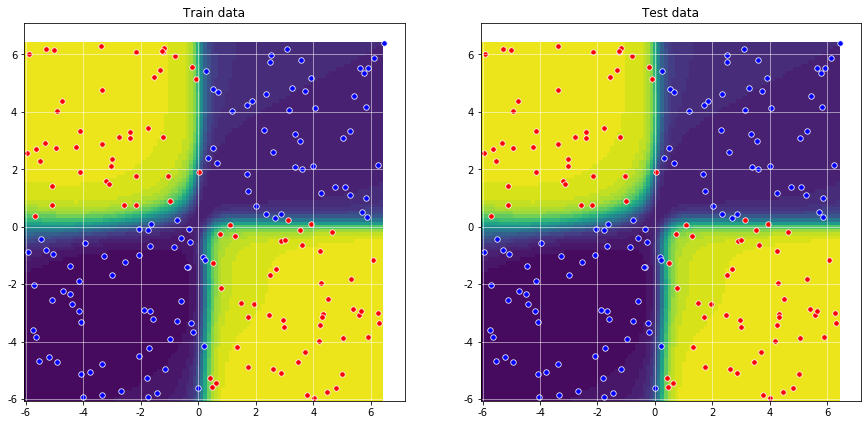

In [28]:
values = np.zeros(shape=(2, 100, 100))

xs = np.linspace(-6.0, 6.0, 100)
ys = np.linspace(-6.0, 6.0, 100)

for i in range(2):
    for xidx, x in enumerate(xs):
        for yidx, y in enumerate(ys):
            values[i, yidx, xidx] = feedforward(np.array([np.array([x, y])]).T)[0][-1]
values = np.asarray(values)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
palette = sns.color_palette("viridis", 32)
cmap = ListedColormap(sns.color_palette(palette).as_hex())

axes[0].imshow(values[0], interpolation='none', cmap=cmap)
axes[0].grid(color='w', linestyle='-', linewidth=0.5)
axes[0].invert_yaxis()

train_data_1 = train_data[train_labels == 1]
train_data_0 = train_data[train_labels == 0]
train_data_1_plot = (train_data_1 + 6) * (100/12)
train_data_0_plot = (train_data_0 + 6) * (100/12)
sns.scatterplot(x=train_data_1_plot[:, 0], y=train_data_1_plot[:, 1], color='red', ax=axes[0], s=30)
sns.scatterplot(x=train_data_0_plot[:, 0], y=train_data_0_plot[:, 1], color='blue', ax=axes[0], s=30)
axes[0].set_title("Train data")

pos_list = np.arange(0, 100, 16)
value_list = np.arange(-6, 8, 2)
axes[0].xaxis.set_major_locator(ticker.FixedLocator((pos_list)))
axes[0].xaxis.set_major_formatter(ticker.FixedFormatter((value_list)))
axes[0].yaxis.set_major_locator(ticker.FixedLocator((pos_list)))
axes[0].yaxis.set_major_formatter(ticker.FixedFormatter((value_list)))


axes[1].imshow(values[1], interpolation='none', cmap=cmap)
axes[1].grid(color='w', linestyle='-', linewidth=0.5)
axes[1].invert_yaxis()

train_data_1 = train_data[train_labels == 1]
train_data_0 = train_data[train_labels == 0]
train_data_1_plot = (train_data_1 + 6) * (100/12)
train_data_0_plot = (train_data_0 + 6) * (100/12)
sns.scatterplot(x=train_data_1_plot[:, 0], y=train_data_1_plot[:, 1], color='red', ax=axes[1], s=30)
sns.scatterplot(x=train_data_0_plot[:, 0], y=train_data_0_plot[:, 1], color='blue', ax=axes[1], s=30)
axes[1].set_title("Test data")

pos_list = np.arange(0, 100, 16)
value_list = np.arange(-6, 8, 2)
axes[1].xaxis.set_major_locator(ticker.FixedLocator((pos_list)))
axes[1].xaxis.set_major_formatter(ticker.FixedFormatter((value_list)))
axes[1].yaxis.set_major_locator(ticker.FixedLocator((pos_list)))
axes[1].yaxis.set_major_formatter(ticker.FixedFormatter((value_list)))